In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torchvision.transforms as transforms
import glob
import torchvision
import time
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [ ]:
!nvidia-smi

Sun Nov 12 08:15:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import RandomChoice

ROOT_DIR_TRAIN = "/content/drive/MyDrive/PlantDoc-Dataset/train"
ROOT_DIR_TEST = "/content/drive/MyDrive/PlantDoc-Dataset/test"

# Transforms for training with Random Erase
train_transform =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Transforms for validation/testing
test_valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Prepare the Dataset
dataset_train = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=train_transform)
dataset_valid = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=test_valid_transform)
test_dataset = datasets.ImageFolder(root=ROOT_DIR_TEST, transform=test_valid_transform)

train_size = int(0.80 * len(dataset_train))
valid_size = len(dataset_train) - train_size

# Radomize the data indices.
indices = torch.randperm(len(dataset_train)).tolist()
# Training and validation sets.
train_dataset = Subset(dataset_train, indices[:-valid_size])
valid_dataset = Subset(dataset_valid, indices[-valid_size:])

# Prepare the Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

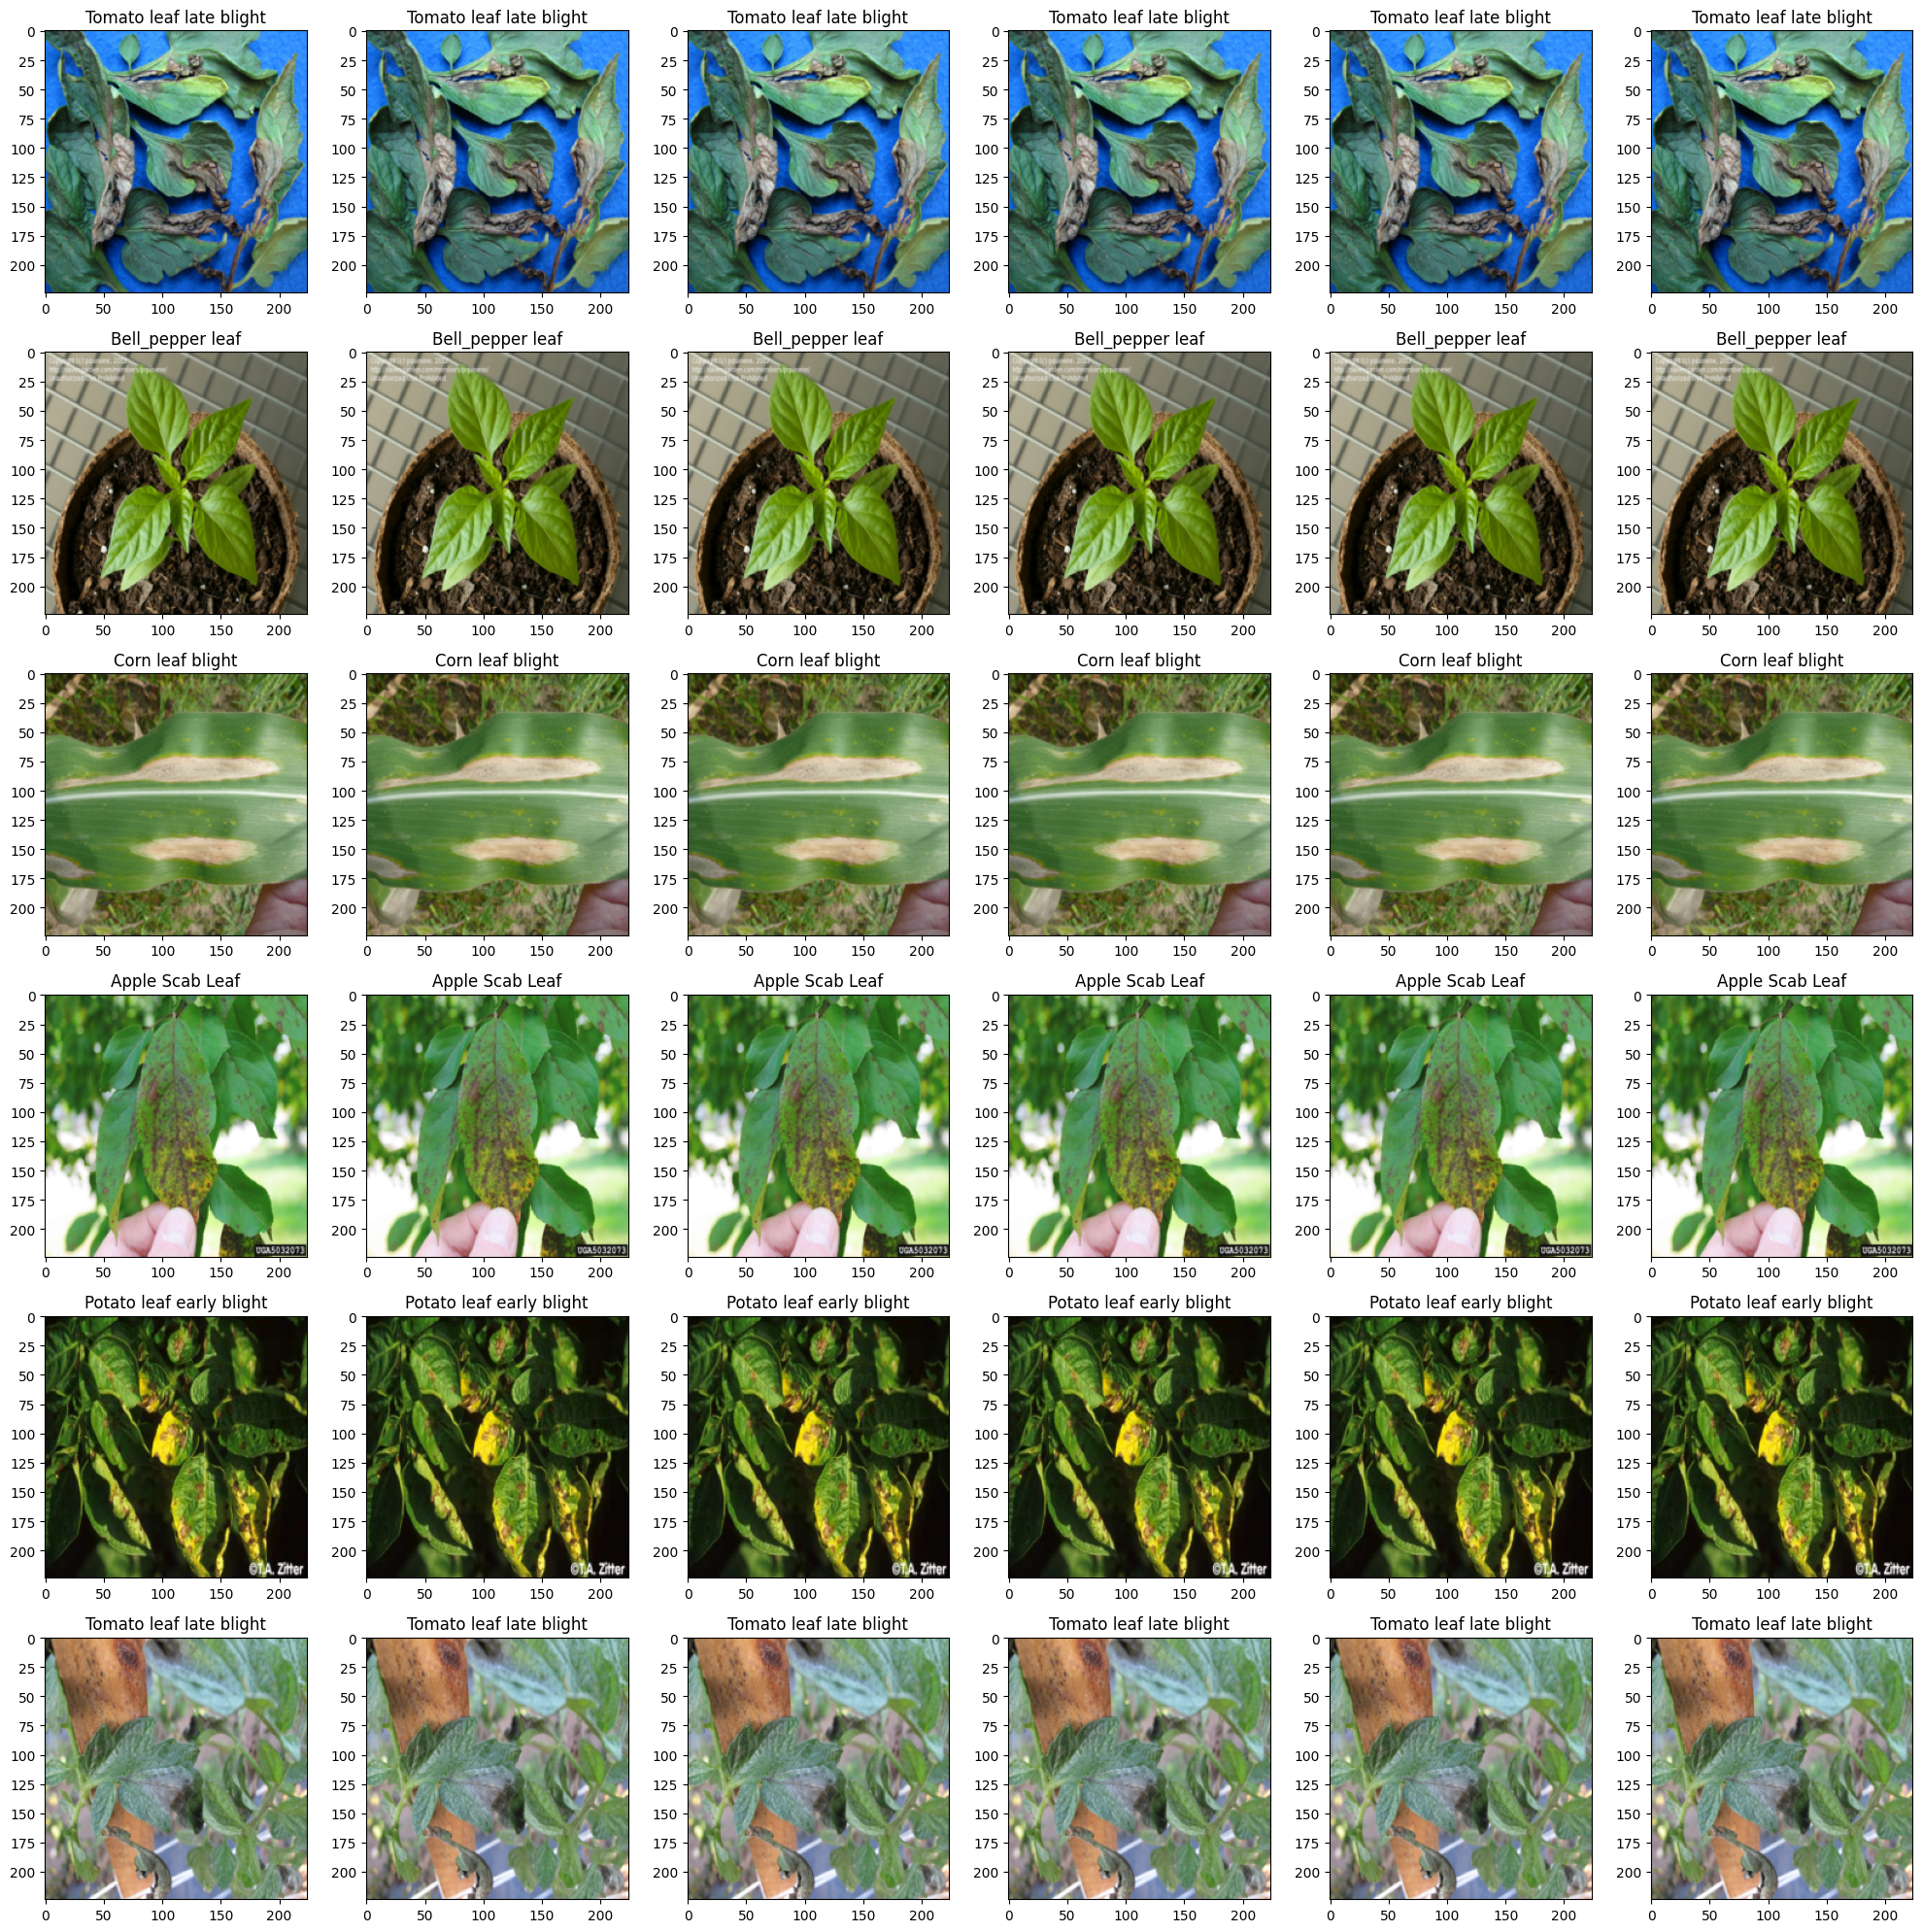

In [ ]:
def show_dataset(dataset_train, n=6):
    fig, axs = plt.subplots(n, n, figsize=(20, 20))

    for row in range(n):
        idx = np.random.randint(len(dataset_train))  # select the same index for each row
        for col in range(n):
            images, labels = dataset_train[idx]
            images = images.permute(1, 2, 0)  # CxHxW -> HxWxC
            images = images * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])  # denormalize
            images = (images * 255).byte().numpy()  # convert to uint8 numpy array
            axs[row, col].imshow(images)
            axs[row, col].set_title(dataset_train.classes[labels])
            axs[row, col].axis()

    plt.tight_layout()
    plt.show()

# Show Dataset
show_dataset(dataset_train)

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 11.2 MB/s eta 0:00:00


In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 27.0/78.2 GB disk)


In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchinfo import summary

# โหลดโมเดล YOLOv8 ที่ผ่านการฝึกอบรมล่วงหน้าด้วยไฟล์น้ำหนัก 'yolov8n-cls.pt'
model = YOLO('/content/drive/MyDrive/PlantDoc-Dataset/IS2/yolov8-cls.yaml') # build a new model from YAML

# Set the device (CPU or GPU)
model.to(device)

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU()
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU()


In [ ]:
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
import numpy as np

def train_model(model, criterion, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

def validate_model(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
# Set the number of folds
num_folds = 5

# Prepare the data
X = np.arange(len(dataset_train))
y = np.array([label for _, label in dataset_valid.imgs])

# Set up the StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store fold results
fold_train_losses = []
fold_valid_losses = []
fold_test_losses = []
fold_train_accs = []
fold_valid_accs = []
fold_test_accs = []

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Create data loaders for the current fold
    train_data = Subset(dataset_train, train_index)
    valid_data = Subset(dataset_valid, valid_index)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load and prepare the model
    model.to(device)

    # Set the criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train and validate the model
    num_epochs = 50
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_test_losses = []
    epoch_train_accs = []
    epoch_valid_accs = []
    epoch_test_accs = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = validate_model(model, criterion, valid_loader, device)
        test_loss, test_acc = test_model(model, criterion, test_loader, device)

        epoch_train_losses.append(train_loss)
        epoch_valid_losses.append(valid_loss)
        epoch_test_losses.append(test_loss)
        epoch_train_accs.append(train_acc)
        epoch_valid_accs.append(valid_acc)
        epoch_test_accs.append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc * 100:.4f} "
              f"Valid Loss: {valid_loss:.4f} Valid Accuracy: {valid_acc * 100:.4f} "
              f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc * 100:.4f}")

    fold_train_losses.append(epoch_train_losses)
    fold_valid_losses.append(epoch_valid_losses)
    fold_test_losses.append(epoch_test_losses)
    fold_train_accs.append(epoch_train_accs)
    fold_valid_accs.append(epoch_valid_accs)
    fold_test_accs.append(epoch_test_accs)

    print("Finished Fold")
    print("=" * 50)

engine/trainer: task=classify, mode=train, model=/content/drive/MyDrive/PlantDoc-Dataset/IS2/yolov8-cls.yaml, data=imagenet10, epochs=100, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=F

Fold 1/5


  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    343050  ultralytics.nn.modules.head.Classify         [256, 10]                     
YOLOv8-cls summary: 99 layers, 1451098 parameters, 1451098 gradients, 3.4 GFLOPs
TensorBoard: Start with 'tensorboard --logdir runs/classify/train3', view at http://localhost:6006/
AMP: running Automati

RuntimeError: ignored